In [1]:
import osmnx as ox
import numpy as np
import open3d as o3d
import os
from horizon import load, project, signal
# auto reload packages
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Extract viewpoints and skylines from anywhere
## Get interesting viewpoints from OSM

In [2]:
tag = {'tourism':'viewpoint'}
place = 'Vosges, France'

In [3]:
viewpoints = ox.features_from_place(place, tag)['geometry']
# keep only points
viewpoints = viewpoints[viewpoints.geom_type=='Point']
# viewpoints.head()

<Axes: >

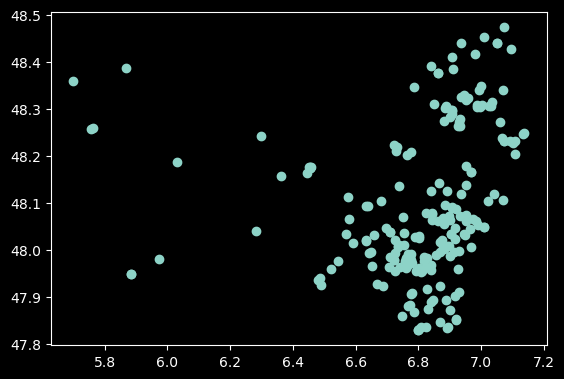

In [4]:
viewpoints.plot()

A lot of points are too close to each other, we don't need all of them as they probably have similar skylines
## Reduce the viewpoints

In [5]:
# convert geoseries to numpy array of shape (N,2)
split_point = lambda point: np.array([point.y, point.x])
v_split_point = np.vectorize(split_point, signature='()->(2)')
np_viewpoints = v_split_point(np.asarray(viewpoints))

In [6]:
# project to Lambert 93
np_viewpoints = project.array_to_xy(np_viewpoints)

In [7]:
def get_ids_to_filter(dist_matrix, threshold):
    args = np.argwhere((dist_matrix<threshold) & (dist_matrix!=0))[:,0]
    args = np.unique(args)
    return args

In [8]:
# compute distance between each pair of points
dist_matrix = project.distance_points_points(np_viewpoints, np_viewpoints)
# remove points closer than 5km to another
to_remove = get_ids_to_filter(dist_matrix, 5000)
np_viewpoints = np.delete(np_viewpoints, to_remove, axis=0)
print('Number of viewpoints :', len(np_viewpoints))

Number of viewpoints : 43


In [9]:
# same for indexes
indexes = viewpoints.index.to_frame()['osmid'].to_list()
indexes = np.delete(indexes, to_remove, axis=0)

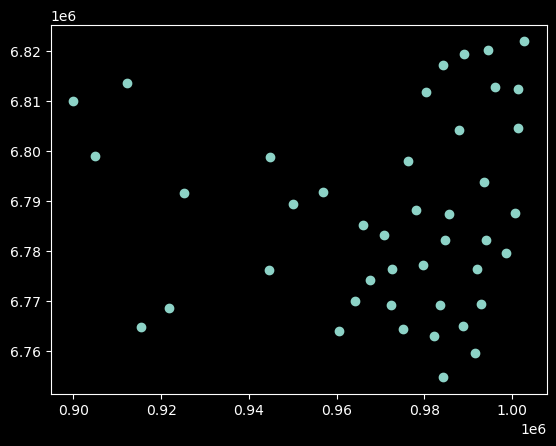

In [10]:
import matplotlib.pyplot as plt
plt.scatter(np_viewpoints[:,0], np_viewpoints[:,1])

## Download terrain data

In [11]:
terrain_data = "../../data/terrain/OSM/"
horizon_data = "../../data/horizon/OSM/"
place_name = place.split(',')[0]
n=5
margin_distance=50

In [12]:
bounds = viewpoints.total_bounds.tolist()
bounds[:2] = load.bounds_from_distance(bounds[1], bounds[0], margin_distance)[:2]
bounds[2:] = load.bounds_from_distance(bounds[3], bounds[2], margin_distance)[2:]
bounds

[5.364671204160852, 47.6042950499775, 7.476612525048835, 48.6993102500225]

In [ ]:
if not os.path.exists(terrain_data+place_name+'.xyz'):
    load.download_from_eio(terrain_data, place_name, bounds=bounds)
pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')

In [59]:
o3d.visualization.draw_geometries([pc])

## Extract skyline for each viewpoint

In [60]:
def crop_pc(pc, view_point, distance=50_000):
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(view_point[0]-distance, view_point[1]-distance, -1000), 
                                            max_bound=(view_point[0]+distance, view_point[1]+distance, 5000))
    return pc.crop(bbox)

In [61]:
def get_viewpoint_altitude(pc, view_point):
    terrain_points = np.asarray(pc.points)
    closest = project.closest_point(terrain_points[:,0:2], view_point[:2])
    view_point = np.append(view_point,  terrain_points[closest][2] + 3) # add 3m to not be at ground level
    return view_point

In [ ]:
# for each viewpoint
for i, index in enumerate(indexes):
    # get the viewpoint (2D) coordinates and id
    name = str(index)
    view_point = np_viewpoints[i]
    # download and process data if unknown
    if not os.path.exists(horizon_data+name+'.npy'):
        # crop terrain data
        cropped_pc = crop_pc(pc, view_point)
        # get view point altitude
        view_point = get_viewpoint_altitude(cropped_pc, view_point)
        # extract skyline
        spherical = project.array_cartesian_to_spherical(cropped_pc.points, view_point)
        angles = project.get_deg_angles(spherical)
        skyline = project.get_skyline(angles, savepath=horizon_data+name)
    # otherwise, load directly from files
    else:
        skyline = np.load(horizon_data+name+'.npy').astype(float)

    # display skyline
    smooth_skyline = signal.smooth(skyline, n)
    signal.plot_skyline(smooth_skyline, 'Skyline '+name)
